# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pickle
import joblib
import time
from utils import *

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [2]:
# import saved cleaned data
database_filepath = '../data/merged_data_clean.pkl'
df_clean = pickle.load(open(database_filepath, "rb"))

In [3]:
df_clean.head()

,DSL_FLAG,GREEN_AVANTGARDE,HH_DELTA_FLAG,KBA05_SEG6,KONSUMZELLE,SOHO_KZ,UNGLEICHENN_FLAG,VERS_TYP,ANREDE_KZ,OST_WEST_KZ,...,KBA05_MAXVORB,D19_KINDERARTIKEL,KBA05_KW2,KBA05_ZUL1,KBA05_ANTG2,KBA05_ANTG4,CJT_GESAMTTYP,SEMIO_FAM,VERDICHTUNGSRAUM,TYPE
2,1.0,1,0.0,0.0,0.0,0.0,0.0,1.0,2.0,W,...,1.0,0,2.0,2.0,3.0,0.0,3.0,1.0,1.0,general
3,1.0,0,NaN,0.0,0.0,0.0,0.0,1.0,2.0,W,...,2.0,0,4.0,3.0,1.0,0.0,2.0,1.0,0.0,general
4,1.0,0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,W,...,1.0,0,2.0,3.0,4.0,0.0,5.0,4.0,1.0,general
5,1.0,0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,W,...,1.0,0,5.0,3.0,2.0,0.0,2.0,4.0,0.0,general
6,1.0,0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,W,...,3.0,0,3.0,3.0,2.0,0.0,5.0,5.0,35.0,general


In [4]:
general_clean = df_clean.loc[df_clean['TYPE']=='general']
general_clean.drop(columns=['TYPE'], inplace=True)

C:\Users\ADMIN\anaconda3\envs\ml\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [5]:
customer_clean = df_clean.loc[df_clean['TYPE']=='customer']
customer_clean.drop(columns=['TYPE'], inplace=True)

### PCA

In [6]:
df_feats = general_clean
# df_type = df_clean[['TYPE']]
del general_clean
del df_clean

In [7]:
def create_column_transformer(binary_cols, categorical_cols, numerical_cols):
    '''This function deals designated columns and imputes missing data.
    Args:
    df: demographic dataframe
    returns: none
    '''

    # Transform-impute Pipeline
    # Categorical
    categorical_pipeline = Pipeline([
        ('bin_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Binary
    binary_pipeline = Pipeline([('bin_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])

    # Numerical
    numerical_pipeline = Pipeline([
        ('num_impute', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('num_scale', StandardScaler())
    ])

    # Combined pipeline
    transformers = [('binary', binary_pipeline, binary_cols),
                    ('categorical', categorical_pipeline, categorical_cols),
                    ('numerical', numerical_pipeline, numerical_cols)]
    column_transformer = ColumnTransformer(transformers=transformers)

    return column_transformer

In [8]:
# create column transformer
column_transformer = create_column_transformer(binary_cols, categorical_cols, numerical_cols)

In [9]:
# Impute, transform, and standardize features
df_trans = column_transformer.fit_transform(df_feats)

In [10]:
# Fit PCA object
pca = PCA().fit(df_trans)

In [11]:
# Investigate the variance accounted for by each principal component.
def pca_scree_plot(pca):
    """
    Plots PCA scree plot.
    
    Input: pca - fitted PCA object
    Output: scree plot
    """
    
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    cumvals = np.cumsum(vals)

    fig = plt.figure(figsize=(16,6))
    ax = plt.subplot()
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)

    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance')
    plt.title('Cumulative explained variance ratio plot')
    
    return fig

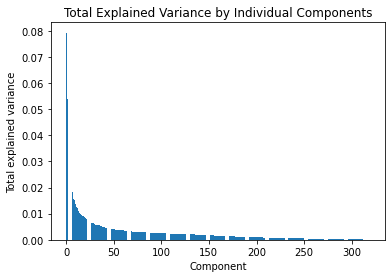

In [12]:
# Investigate the variance accounted for by each principal component.
num_components=len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
vals = pca.explained_variance_ratio_
plt.bar(ind, vals)
plt.xlabel('Component')
plt.ylabel('Total explained variance')
plt.title('Total Explained Variance by Individual Components')
plt.savefig('pca_plot.png', dpi=500)
plt.show()

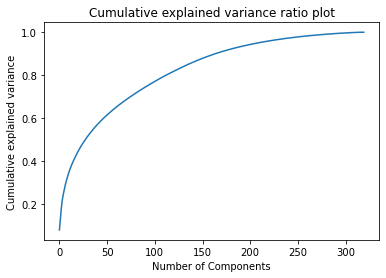

In [13]:
cumvals = np.cumsum(vals)
plt.plot(cumvals)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative explained variance')
plt.title('Cumulative explained variance ratio plot')
plt.savefig('pca_cummulative_plot.png', dpi=500)
plt.show()

In [14]:
threshold = .90
num_components = np.argmax(cumvals > threshold)

print('{} components explain {}% of variance in the dataset.'.format(num_components, round(cumvals[num_components],2)*100))

164 components explain 90.0% of variance in the dataset.


From 319 components, 164 components explain 90% of variance in the dataset. The dataset can be reduced to almost half of its feature range while only losing 10% of variance.

In [15]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(num_components)
df_pca = pca.fit(df_trans)
df_reduced = pd.DataFrame(df_pca.transform(df_trans))

In [16]:
top_three_pca = pca.explained_variance_ratio_[:3]

In [17]:
print("The first three components explain {:.1%} of variance.".format(top_three_pca.sum()))

The first three components explain 18.1% of variance.


In [18]:
def map_component_to_features(pca, component, column_names):
    """
    Returns weights of features for a selected component.
    
    Input:
    pca - fitted PCA object
    component - PCA component of interest
    column_names - list of original feature names
    
    Output:
    df_features - sorted DataFrame with feature weigths
    """
    
    weights_array = pca.components_[component]
    df_trans = pd.DataFrame(weights_array, index = column_names, columns=['weight'])
    return df_trans.sort_values(by='weight', ascending=False).round(2)

In [37]:
# get columns names of the features after transformation
categorical_cols_onehot = list(column_transformer.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_cols))
df_trans_cols = binary_cols + categorical_cols_onehot + numerical_cols 
len(df_trans_cols)

320

In [38]:
print("Component 1 explains {:.1%} of variance and is determined by: ".format(top_three_pca[0]))
map_component_to_features(pca, 0, df_trans_cols).head()

Component 1 explains 7.9% of variance and is determined by: 


,weight
MOBI_REGIO,0.15
KBA13_ANTG1,0.14
LP_STATUS_FEIN,0.14
MOBI_RASTER,0.14
KBA05_ANTG1,0.14


Component 1 explains 8.1% total variance, determined by the mobility and social status of the person.

In [41]:
print("Component 2 explains {:.1%} of variance and is determined by: ".format(top_three_pca[1]))
map_component_to_features(pca, 1, df_trans_cols).head()

Component 2 explains 5.4% of variance and is determined by: 


,weight
KBA13_HERST_BMW_BENZ,0.19
KBA13_MERCEDES,0.16
KBA13_SEG_OBEREMITTELKLASSE,0.16
KBA13_BMW,0.16
KBA13_SITZE_4,0.15


Component 2 explains 5.5% total variance, determined by the car a person owns (KBA13_HERST_BMW_BENZ and KBA13_MERCEDES).

In [42]:
print("Component 3 explains {:.1%} of variance and is determined by: ".format(top_three_pca[2]))
map_component_to_features(pca, 2, df_trans_cols).head()

Component 3 explains 4.8% of variance and is determined by: 


,weight
CJT_TYP_1,0.19
FINANZ_SPARER,0.18
ONLINE_AFFINITAET,0.17
FINANZ_UNAUFFAELLIGER,0.15
ALTERSKATEGORIE_FEIN,0.15


Component 3 explains 4.6% total variance, determined by dominating movement in the person's youth (CJT_TYP_1), the person's financial behaviour (FINANZ_SPARER), and , online affinity (ONLINE_AFFINITAET).

### K-Mean Clustering

In [44]:
N = df_reduced.shape[0]
mean_d = []
centers = range(1, 31)
for k in centers:
#     print(k)
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=k)
    model = kmeans.fit(df_reduced.sample(200000))
    
    # compute the average within-cluster distances.
    mean_d.append(abs(model.score(df_reduced))/N)

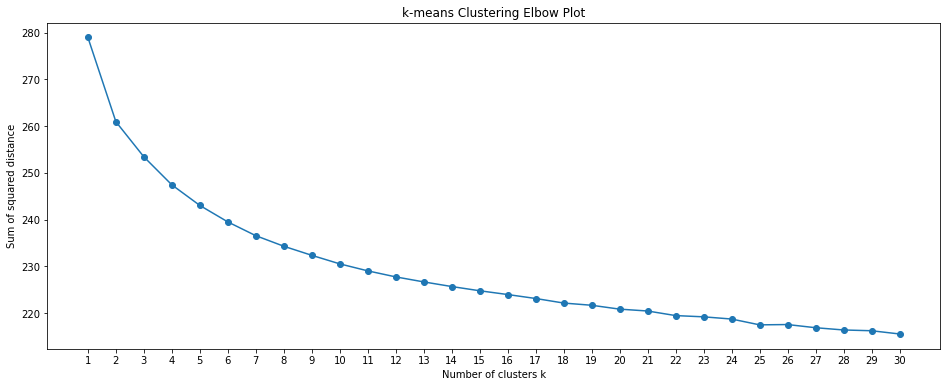

In [45]:
# Plot sse against k
plt.figure(figsize=(16, 6))
plt.plot(centers, mean_d, '-o')
plt.title('k-means Clustering Elbow Plot')
plt.xlabel("Number of clusters k")
plt.ylabel("Sum of squared distance")
plt.xticks(list(range(1,31)))
plt.show
plt.savefig('elbow_plot.png', dpi=500);

There is no clear elbow in the plot. The inertia or sum of squared distances drops significantly until around 9 clusters and then basically flattens out, so 10 clusters are chosen as final number.

### Combine PCA and K-Mean into Pipeline

In [43]:
# Set PCA and KMeans parameters
pca_components = 164
kmeans_clusters = 10

In [44]:
def create_column_transformer(binary_cols, categorical_cols, numerical_cols):
    '''This function deals designated columns and imputes missing data.
    Args:
    df: demographic dataframe
    returns: none
    '''

    # Transform-impute Pipeline
    # Categorical
    categorical_pipeline = Pipeline([
        ('bin_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Binary
    binary_pipeline = Pipeline([('bin_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])

    # Numerical
    numerical_pipeline = Pipeline([
        ('num_impute', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('num_scale', StandardScaler())
    ])

    # Combined pipeline
    transformers = [('binary', binary_pipeline, binary_cols),
                    ('categorical', categorical_pipeline, categorical_cols),
                    ('numerical', numerical_pipeline, numerical_cols)]
    column_transformer = ColumnTransformer(transformers=transformers)

    return column_transformer


def build_cluster_pipeline(column_transformer, pca_components, kmeans_clusters):

    # Create cluster pipeline
    cluster_pipeline = Pipeline([
        ('transform', column_transformer),
        ('reduce', PCA(n_components=pca_components)),
        ('cluster', KMeans(n_clusters=kmeans_clusters, init='k-means++'))
    ])

    return cluster_pipeline

In [45]:
# build pipeline
column_transformer = create_column_transformer(binary_cols, categorical_cols, numerical_cols)
cluster_pipeline = build_cluster_pipeline(column_transformer, pca_components=pca_components, kmeans_clusters=kmeans_clusters)

In [46]:
# Fit cluster pipeline and create clustered general population dataframe
cluster_pipeline.fit(df_feats)
general_clustered = pd.DataFrame(cluster_pipeline.predict(df_feats), columns = ['Cluster'])

In [51]:
print('Saving model...')
f = open('../results/clust_model' + str(num_components) + '.pkl', 'wb')
pickle.dump(cluster_pipeline, f)

Saving model...


### Cluster Analysis

In [53]:
# Create clustered customers dataframe
customers_clustered = pd.DataFrame(cluster_pipeline.predict(customer_clean), columns = ['Cluster'])

In [54]:
# Get cluster sizes in each dataset
general_clusters = general_clustered['Cluster'].value_counts().sort_index()
customer_clusters = customers_clustered['Cluster'].value_counts().sort_index()

In [62]:
# Concat both dataframes to one
clusters = pd.concat([general_clusters, customer_clusters], axis=1).reset_index()
clusters.columns = ['cluster', 'general_count', 'customers_count']
clusters['cluster']+=1

In [63]:
# Calculate share of each cluster
clusters['general_share'] = clusters['general_count']/clusters['general_count'].sum()*100
clusters['customers_share'] = clusters['customers_count']/clusters['customers_count'].sum()*100
clusters['diff_share'] = clusters['customers_share'] - clusters['general_share']

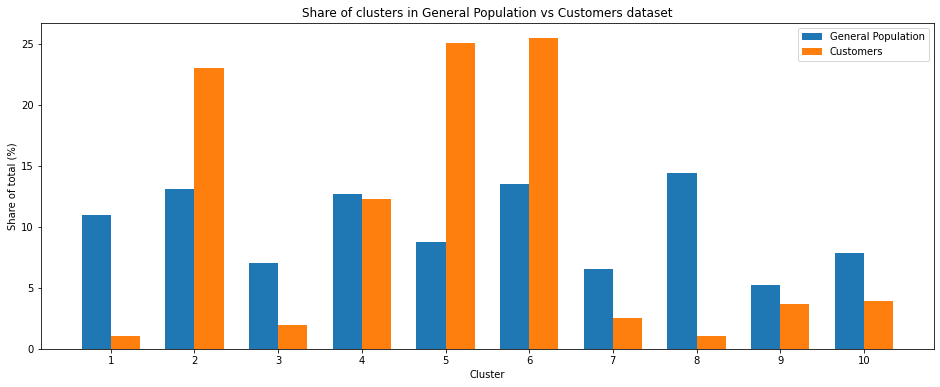

In [64]:
# Plot clusters 
fig, ax = plt.subplots(figsize=(16,6))

ind = np.arange(kmeans_clusters)    # the x locations for the groups
width = 0.35         # the width of the bars

p1 = ax.bar(ind, clusters['general_share'], width, bottom=0)
p2 = ax.bar(ind + width, clusters['customers_share'], width, bottom=0)

ax.set_title('Share of clusters in General Population vs Customers dataset')
ax.set_ylabel('Share of total (%)')
ax.set_xlabel('Cluster')

ax.set_xticks(ind + width / 2)
ax.set_xticklabels(clusters['cluster'])
ax.legend((p1[0], p2[0]), ('General Population', 'Customers'))
ax.autoscale_view()

plt.savefig('clusters_1.png', dpi=500);

For customers dataset, cluster 2, 4, 5, and 6 are the biggest clusters 

In [75]:
# Compute the total number of customers mapped to the majour clusters
clusters['customers_share'][clusters.index.isin([1, 3, 4, 5])].sum()

85.85248763456504

## Part 2: Cluster Mailout Marketing Data

In [98]:
mailout_raw = pd.read_csv('../data/Udacity_MAILOUT_052018_TRAIN.csv')

C:\Users\ADMIN\anaconda3\envs\ml\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [99]:
mailout_clean = load_data_pkl('../data/mailout_train_clean.pkl')

#### Segment

In [100]:
# predict clusters for each records in mailout_train set
mailout_clustered = pd.DataFrame(cluster_pipeline.predict(mailout_clean), columns = ['Cluster'])

In [101]:
# create dataframe of mailout features, cluster, and RESPONSE value
mailout_clustered = mailout_clean.join(mailout_clustered)
mailout_clustered = mailout_clustered.join(mailout_raw['RESPONSE'])

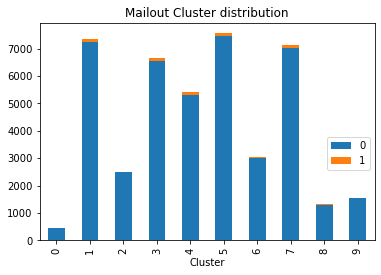

In [119]:
# plot distribution of clusters, by RESPONSE
plot_data = mailout_clustered[['RESPONSE', 'Cluster']]
# plot_data['RESPONSE'] = plot_data.RESPONSE.apply(lambda x: 'Customer' if x==1 else 'General Population')
counts = plot_data.groupby('RESPONSE').Cluster.value_counts().unstack(0)
ax = counts.plot.bar(stacked=True)
plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
plt.title('Mailout Cluster distribution')

plt.savefig('mailout_cluster_distribution.png', dpi=500)

In [103]:
# save dataframe with clusters
mailout_clustered_filepath = '../data/mailout_train_clustered.pkl'
joblib.dump(mailout_clustered, open(mailout_clustered_filepath, 'wb'))
print('Cluster prediction results saved!')

Cluster prediction results saved!
